In [40]:
"""
Created on Tue Jul 25 15:45:54 2023

@author: gurasog
"""


import torch 
import gymnasium as gym 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
from stable_baselines3.common.atari_wrappers import ClipRewardEnv,EpisodicLifeEnv,FireResetEnv, MaxAndSkipEnv, NoopResetEnv
import random
import torch.optim as optim
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Resize, InterpolationMode

In [ ]:
'''TO DO 


1. Make separate class for utils functions
2. Check the evaluation 
3. Add an automatic model saving after the completion of somthing


'''

### Utils functions

In [7]:
def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id, render_mode="rgb_array")
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)

        return env

    return thunk


def action_to_one_hot(ind):
    one_hot=np.zeros(env.action_space.n)
    one_hot[ind]+=1
    one_hot=to_tensor(one_hot)
    return one_hot

def stack_state_and_action(state, one_hot_action):
    
    if not torch.is_tensor(state):
        state=to_tensor(state)
    if not torch.is_tensor(one_hot_action):
        one_hot_action=to_tensor(one_hot_action)
    
    return torch.hstack((state,one_hot_action))


def action_to_one_hot_table(inds):
    #inds=inds.flatten().cpu().detach().numpy()
    one_hot=np.zeros((len(inds),env.action_space.n))
    one_hot[range(len(inds)), inds]=1
    one_hot=to_tensor(one_hot)
    return one_hot



def stack_state_and_action(state, one_hot_action):
    
    if not torch.is_tensor(state):
        state=to_tensor(state)
    if not torch.is_tensor(one_hot_action):
        one_hot_action=to_tensor(one_hot_action)
    
    return torch.hstack((state,one_hot_action))

def to_tensor(x, dtype=torch.float32):
    try:
        x=torch.tensor(x, dtype=dtype).to(device)
    except:
        x=torch.Tensor(x, dtype=dtype).to(device)
    
    return x

downscale = Resize(size = (70, 110), interpolation = InterpolationMode.NEAREST)

def get_image(envs):    
    s_im=envs.call('render')[0].transpose(2,0,1)
    s_im=downscale(torch.Tensor(s_im))/255
    s_im=np.expand_dims(s_im, 0)
    
    return to_tensor(s_im)

def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    '''отрицательный слоуп постепенно снижается'''
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)


def rescale_reward(reward):
    reward=reward[0]
    if reward==20:
        reward_sc=1
    elif reward==-10:
        reward_sc=-0.1
    else:
        reward_sc=-0.01
        
    return np.array([reward_sc])

### Parse parameters and hyperparameters 

In [9]:
def parse_args():
    
    class Args:
        
        def __init__(self):
            pass
        
    args_dict = dict(batch_size=128,
              buffer_size=1000000,
              capture_video=False,
              cuda=True, end_e=0.01,
              env_id='Taxi-v3',
              exp_name='DQN_clean_RL',
              exploration_fraction=0.1,
              gamma=0.99, hf_entity='',
              learning_rate=0.0001,
              learning_starts=80000,
              num_envs=1,
              save_model=True,
              seed=1,
              start_e=1,
              target_network_frequency=1000,
              tau=1.0,
              torch_deterministic=True,
              total_timesteps=10000000,
              track=False, train_frequency=4,
              upload_model=False,
              wandb_entity=None, 
              wandb_project_name='cleanRL')
    args = Args()
    args.__dict__ = args_dict
    
    return args

#learning_starts сейчас поставил низкое значение

### Networks

In [10]:
seed_for_env=10
env=gym.make('Taxi-v3', render_mode='rgb_array')
s, _=env.reset(seed=seed_for_env)
device= torch.device("cuda")

In [11]:
class U(nn.Module):
    def __init__(self, env, D=500):
        super().__init__()
        self.D=500
        self.network=nn.Sequential(
            nn.Linear(self.D+env.action_space.n,250),
            nn.ReLU(),
            nn.Linear(250,self.D),
            nn.ReLU(),
            nn.Linear(self.D, self.D )
            )

    def forward(self, x):
        
        output=[]
        
        if len(x)==1:
            for i in range(env.action_space.n):
                x=x.flatten()
                one_hot=action_to_one_hot(i).flatten()
                x_one_hot=stack_state_and_action(x, one_hot)
                value=self.network(x_one_hot)
                output.append(value)
            return torch.stack(output)
        else: 
            
            for i in range(env.action_space.n):
                one_hot=action_to_one_hot_table(np.full(len(x),i))
                x_one_hot=stack_state_and_action(x, one_hot)
                value=self.network(x_one_hot)
                output.append(value)
                
            return torch.stack(output).permute(1,0,2)
                
            
            
class Phi(nn.Module):
    
    def __init__(self, env, D=500):
        super().__init__()
        self.D=D
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, 7, stride=3),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 1, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4608, 500),
            nn.ReLU(),
            nn.Linear(500, self.D),
        )

    def forward(self, x):
        return self.network(x)
    
    
class G(nn.Module):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Linear(500,4608),
            nn.Unflatten(dim=1, unflattened_size=(32, 9, 16)),
            nn.ConvTranspose2d(32,32,1,1),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,5,2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16,3,7,3, padding=(0,1) ),
            nn.ReLU()
            )

    def forward(self, x):
            return self.network(x)
        
        
class R(nn.Module):
    def __init__(self,  D=500):
        super().__init__()
        self.D=500
        self.network=nn.Sequential(
            nn.Linear(self.D,1, bias=False)
        )
        
    def forward(self, x):
        return self.network(x)
          


In [12]:
def get_q_values(m, weights):
    return torch.matmul(m,w.T)
    
def get_r_weights(r):
    values=[param for param in r.parameters()]
    w=values[0].data
    return w


def loss_R(obs,r, rewards, loss_fn, encoder):
    phi=encoder(obs)
    w=get_r_weights(r)
    rew_estimate=phi*w
    #print(rew_estimate.shape)
    loss=loss_fn(rew_estimate,rewards)
    return loss


def loss_FG(data, loss_fn, encoder, decoder):    
    
    encoded_data=encoder(data)
    decoded_data=decoder(encoded_data)
    loss=loss_fn(data, decoded_data)
    return loss + torch.mean(torch.square(encoded_data))


def loss_U(image_data_state,image_data_next_state,actions ,loss_fn, dones,u_net,target_u_net, gamma=0.99 ):
    
    phi=encoder(image_data_state).detach()
    phi_next=encoder(image_data_next_state).detach()
    
    with torch.no_grad():
        m_n=target_u_net.forward(x=phi_next)
        some_estimate=torch.matmul(m_n, get_r_weights(r_net).T ).squeeze()
        m_n_inds=torch.argmax(some_estimate, axis=1)
        m_n_max=m_n[torch.arange(len(m_n_inds)),m_n_inds,:]
        target=phi+gamma*m_n_max* (1 - dones)
    
    m_c=u_net.forward(x=phi)
    u_cur=m_c[torch.arange(len(phi)),actions.flatten(),:]
    #print(u_cur)
    
    return loss_fn(target,u_cur)

    
def loss_U(image_data_state,image_data_next_state,actions ,loss_fn, dones, gamma=0.99 ):
    
    phi=encoder(image_data_state).detach()
    phi_next=encoder(image_data_next_state).detach()
    
    
    m_n=u_net.forward(x=phi_next)
    some_estimate=torch.matmul(m_n, get_r_weights(r_net).T ).squeeze()
    m_n_inds=torch.argmax(some_estimate, axis=1)
    m_n_max=m_n[np.arange(len(m_n_inds)),m_n_inds,:]
    target=phi+gamma*m_n_max* (1 - dones)
    
    
    m_c=u_net.forward(x=phi)
    u_cur=m_c[range(len(phi)),actions.flatten(),:]
    #print(u_cur)
    
    return loss_fn(target,u_cur)



### Main

In [17]:

if __name__ == "__main__":
    import stable_baselines3 as sb3

    if sb3.__version__ < "2.0":
        raise ValueError(
            """Ongoing migration: run the following command to install the new dependencies:
poetry run pip install "stable_baselines3==2.0.0a1" "gymnasium[atari,accept-rom-license]==0.28.1"  "ale-py==0.8.1" 
"""
        )
    args = parse_args()
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    if args.track:
        import wandb

        wandb.init(
            project=args.wandb_project_name,
            entity=args.wandb_entity,
            sync_tensorboard=True,
            config=vars(args),
            name=run_name,
            monitor_gym=True,
            save_code=True,
        )
    writer = SummaryWriter(f"runs/non_zero_buffer_{run_name}")
    writer.add_text(
        "hyperparameters",
        "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
    )

    # TRY NOT TO MODIFY: seeding
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic
    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")
    envs = gym.vector.SyncVectorEnv(
        [make_env(args.env_id, args.seed + i, i, args.capture_video, run_name) for i in range(args.num_envs)]
    )
    
    
    # env setup
    assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"
    
    dict_of_observations={}
    
    r_net=R().to(device)
    encoder=Phi(env).to(device)
    decoder=G().to(device)
    u_net=U(env).to(device)
    target_u_net=U(env).to(device) 
    target_u_net.load_state_dict(u_net.state_dict())
    
    
    opt_R=torch.optim.Adam(r_net.parameters(), lr=args.learning_rate)    
    opt_U=torch.optim.Adam(u_net.parameters(), lr=args.learning_rate)
    params_to_optimize=[  {'params': encoder.parameters()}, {'params': decoder.parameters()}  ]
    opt_autoencoder=torch.optim.Adam(params_to_optimize, lr=0.001)
    
    '''
    Realizarion with the target network that is used to somehow simplify the computation.
    Didn't show some sigificant change in performance in comparison with the previous model. 
    
    target_network = QNetwork(envs).to(device)
    target_network.load_state_dict(q_network.state_dict())
    '''
    
    loss_r_net=nn.MSELoss()
    loss_autoencoder=nn.MSELoss() 
    loss_u_net=nn.MSELoss()
    
    
   
    rb = ReplayBuffer(
        args.buffer_size,
        envs.single_observation_space,
        envs.single_action_space,
        device,
        optimize_memory_usage=True,
        handle_timeout_termination=False,
    )
    
    '''
    The central part of ths version. Adding and additional replay buffer to improve the reward.
    '''
        
    rb_non_zero = ReplayBuffer(
        args.buffer_size,
        envs.single_observation_space,
        envs.single_action_space,
        device,
        optimize_memory_usage=True,
        handle_timeout_termination=False,
    )
    
    
    
    start_time = time.time()
    obs, _ = envs.reset(seed=args.seed)
    
    for global_step in range(args.total_timesteps):
        
        # ALGO LOGIC: put action logic here
        epsilon = linear_schedule(args.start_e, args.end_e, args.exploration_fraction * args.total_timesteps, global_step)
        if random.random() < epsilon:
            actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
        else:
            with torch.no_grad():
                encoded_obs=encoder(get_image(envs))
                w=get_r_weights(r_net)
                M_s=u_net.forward(encoded_obs)
                q_values=get_q_values(M_s, w)            
                #actions = torch.argmax(q_values, dim=1).cpu().numpy()
                actions = torch.argmax(q_values, dim=0).cpu().numpy()
        
        '''Adding observation in a dictionary to simplify the further computation'''
        if obs[0] in dict_of_observations:
            pass
        else:
            image=get_image(envs)
            dict_of_observations[obs[0]]=image
                
        
        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, rewards, terminated, truncated, infos = envs.step(actions)
        rewards=rescale_reward(rewards)
        

        # TRY NOT TO MODIFY: record rewards for plotting purposes
        if "final_info" in infos:
            for info in infos["final_info"]:
                # Skip the envs that are not done
                if "episode" not in info:
                    continue
                print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)
                writer.add_scalar("charts/epsilon", epsilon, global_step)
        
        
        
        # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
        real_next_obs = next_obs.copy()
        for idx, d in enumerate(truncated):
            if d:
                real_next_obs[idx] = infos["final_observation"][idx]
                
                
        rb.add(obs, real_next_obs, actions, rewards, terminated, infos)
        
        
        '''We put steps with extreme reward into the nob-zero buffer'''
        if rewards[0]!=-0.01:
            rb_non_zero.add(obs, real_next_obs, actions, rewards, terminated, infos)
        '''End of non-zero buffer'''
        
        obs = next_obs
        
        
        '''Start of training'''
             
        if global_step > args.learning_starts:
            if global_step % args.train_frequency == 0:
                data = rb.sample(args.batch_size)
                
                '''Need to transform states values into the images they represent'''
                with torch.no_grad():
                    images=[dict_of_observations[int(i[0])] for i in data.observations]
                    images=torch.stack(images).squeeze()
                    images_next=[dict_of_observations[int(i[0])] for i in data.next_observations]
                    images_next=torch.stack(images_next).squeeze()
                    
                    
                '''The central part of this version. We add samples from the non-zero replay buffer. But only 20% from original batch size '''
                data_non_zero=rb.sample(args.batch_size//5)
                with torch.no_grad():
                    images_non_zero=[dict_of_observations[int(i[0])] for i in data_non_zero.observations]
                    images_non_zero=torch.stack(images_non_zero).squeeze() 
                
                
                images_for_r=torch.vstack((images_non_zero,images[:]))
                rewards_for_r=torch.vstack((data_non_zero.rewards, data_non_zero.rewards[:]))
                loss_r_value=loss_R(images_non_zero,r_net,data_non_zero.rewards,loss_fn=loss_r_net, encoder=encoder)
                '''End of non-zero batch block'''
                
                
                
                #loss_r_value=loss_R(images_non_zero,r_net,data_non_zero.rewards,loss_fn=loss_r_net, encoder=encoder)
                loss_fg_value=loss_FG(images, encoder=encoder,decoder=decoder,loss_fn=loss_autoencoder)
                loss_paired=loss_r_value+loss_fg_value
                
                
                '''Compute current performance for logs. Needs to be reconsidered'''
                with torch.no_grad():
                    encoded_obs=encoder(get_image(envs))
                    w=get_r_weights(r_net)
                    M_s=u_net.forward(encoded_obs)
                    q_values=get_q_values(M_s, w)
                    old_val=q_values 
                    

                    
                '''Logging'''
                if global_step % 100 == 0:
                        #print('write')
                        writer.add_scalar("losses/loss_r_value", loss_r_value, global_step)
                        writer.add_scalar("losses/loss_fg_value", loss_fg_value, global_step)
                        writer.add_scalar("losses/loss_paired", loss_paired, global_step)
                        writer.add_scalar("losses/q_values", old_val.mean().item(), global_step)
                        print("SPS:", int(global_step / (time.time() - start_time)))
                        writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)
                
                
                opt_R.zero_grad()
                opt_autoencoder.zero_grad()
                loss_paired.backward()
                opt_R.step()
                opt_autoencoder.step()
                
                '''This part is commented beacuse we use only one q-netwrok'''
                #loss_u_value=loss_U(images, images_next, data.actions, u_net=u_net, target_u_net=target_u_net,loss_fn=loss_u_net, dones=data.dones)
                loss_u_value=loss_U(images, images_next, data.actions,loss_fn=loss_u_net, dones=data.dones)
                
                if global_step % 100 == 0:
                    writer.add_scalar("losses/loss_u_value", loss_u_value, global_step)
                    
                
                opt_U.zero_grad()
                loss_u_value.backward()
                opt_U.step()
                
                '''This part is commented beacuse we use only one q-netwrok'''   
            #if global_step % args.target_network_frequency == 0:
            #    for target_network_param, q_network_param in zip(target_u_net.parameters(), u_net.parameters()):
            #        target_network_param.data.copy_(
            #            args.tau * q_network_param.data + (1.0 - args.tau) * target_network_param.data
            #        )
                
                
    envs.close()
    writer.close()

global_step=199, episodic_return=[-857.]
global_step=399, episodic_return=[-848.]
global_step=599, episodic_return=[-767.]
global_step=799, episodic_return=[-668.]
global_step=999, episodic_return=[-821.]
global_step=1199, episodic_return=[-767.]
global_step=1399, episodic_return=[-848.]
global_step=1599, episodic_return=[-911.]
global_step=1799, episodic_return=[-902.]
global_step=1999, episodic_return=[-794.]
global_step=2199, episodic_return=[-749.]
global_step=2399, episodic_return=[-821.]
global_step=2599, episodic_return=[-767.]
global_step=2799, episodic_return=[-713.]
global_step=2999, episodic_return=[-776.]
global_step=3199, episodic_return=[-785.]
global_step=3399, episodic_return=[-776.]
global_step=3599, episodic_return=[-767.]
global_step=3799, episodic_return=[-767.]
global_step=3999, episodic_return=[-848.]
global_step=4199, episodic_return=[-677.]
global_step=4399, episodic_return=[-839.]
global_step=4599, episodic_return=[-839.]
global_step=4799, episodic_return=[-668

KeyboardInterrupt: 

### Additional checks

In [28]:
inds_of_states=np.sort(list(dict_of_observations.keys()))

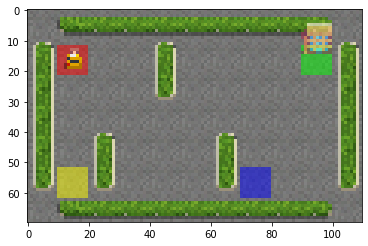

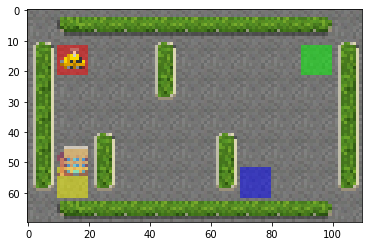

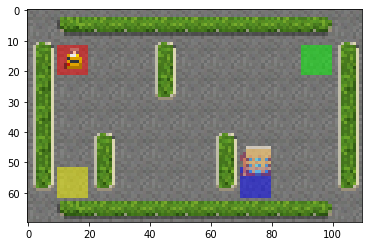

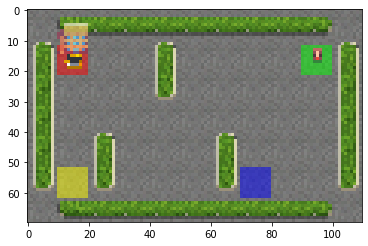

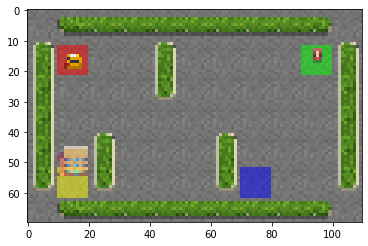

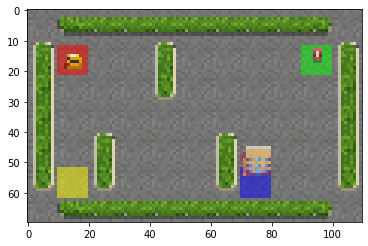

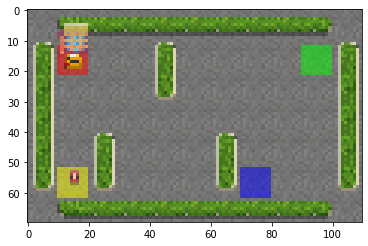

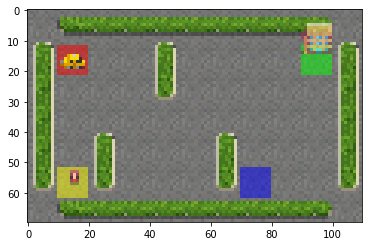

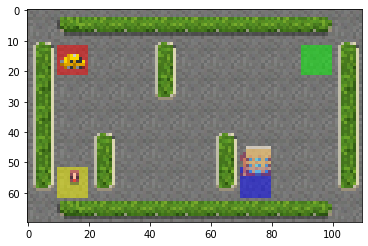

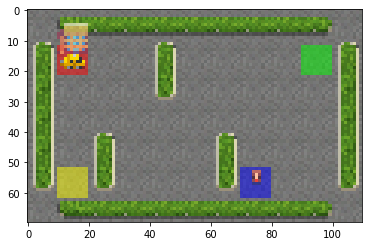

In [39]:
for i in inds_of_states[:10]:
    plt.imshow(dict_of_observations[i].squeeze().permute(1,2,0).detach().cpu().numpy())
    plt.show()